In [5]:
include("../src/ValueFunctions.jl")
include("../src/BeliefStateTransitions.jl")
include("SurplusProduction.jl")

Main.SurplusProduction

# Fishery manamgent model 

In this note book I use the code developed to solve beleif state MDPs to find optimal invetment strategies in monitoring for fisheries manamgent. I assume managers set harvest levels based on noisy observatiosn of the populations biomass at the end of each period and that they can choose to invest in more accurate measurements. In a base case I assume they attempt to maximize the discounted stream of harvest net the costs of monitoring. I also consider a case where tehy maximize for log harvest levels to determine the effects of risk aversion and a case where there is a penelty for low total abundace to determine the effects of a joint harvest and conservation objective. 

## Solution

We solve the manamgers problem as a continuous state MDP using value fuction iteration. This method is based on the bellman equation which defines the value function using a recursive relationship. 

$V(s) = \underset{a_t}{Max}\left\{\int P(x|s)R(x,a_t) dx  + \delta \int V(T(s,a_t,y_t))P(y_t|s,a_t)dy_t\right\}$

were $s$ defines the decision makers beleifs about the true state of the system, $a_t$ is the action they choose to persue. $R$ defines the one period reward given the true state of the system $x$ and the selected action, $P(x|s)$ is the probability of the true stat eof the system is $x$ bevin the beleif state $s$, $T(s,a_t,y_t)$ is the beleif state transition function given the current beleif state, actin and the observation $y_t$, and $P(y_t|s,a_t)$ is the probability of observing $y_t$ give the current state and action.  

This equation cannot ingeneral be solved analytically because $V$ can inprincipal be any arbitary function mapping the state space to the real line. Howeer, it can be solved using fixed point iteration. In essence we guess the value of $V(s)$ and then update this guess by evaluating the right hand size. 

Evaluating the right hand side of the bellman equation requires numerical procedures to aproximate the value function, solve the maximzation problem, evaluate the integrals inside the manximizatin opperator, and methods to aproximate the state transtions. For beleif state MDPs one of the crux is representing the beleif states $s$ and the transition probabilities $T(s,a_t,y_t)$ and $P(y_t|s,a_t)$.


### Beleif state

The decision makers beleif about the true state of the system can in principal be any probabiltiy distribution with with support $R^+$. However in order to solve the decision problem using value function iteration we need to aproximate this potentially infinite dimensional state space with a finite dimensional one. Here we achieve this using a method called density projection. In essence we aproximate the true beleif state with a parametric distribution and use the parameters of this distribution as the state varaible. In this case we applied a log transformed to the dynamcis of the system and represented the decision makers beleif about the log state of the system with a normal distribution. With this aproximation our beleif state $s$ are in the set $\{(\mu,\sigma)|\mu \in R, \sigma \in R\}$, and $P(x|s) = \phi(\frac{log(x)-\mu}{\sigma})$. 

### Beleif state transitions 

The next step is to find a numerical procedure to compute the beleif state transitions. These are determined by the state transition probabilities $G(x_{t+1}|x_t)$ and the observation model $f(y_t|x_t)$. The beleif transitions occur in two steps. First, the beleif state is updated to account for the state transition each period, second the beleif state is updated to using Baye's law to account for the new obsevaiton $y_t$.  

These two steps can be represetned as integral equations. If the beleif state is represtned with pdf $b_t(x)$ the state transition update can be writen

$b_t'(x_{t+1}) = \int G(x_{t+1}|x_t)b_t(x_t)dx_t$. 

applying bayes law for the scond step is writen as

$b_{t+1}(x_{t+1}) = \frac{f(y_{t+1}|x_{t+1})b_t'(x_{t+1})}{\int f(y_{t+1}|x_{t+1})b_t'(x_{t+1}) dx_{t+1}}$.

The probability of making observation $y_{t+1}$ can be found by marginalizing the beleif state after this first update $b_t'(x_{t+1})$

$P(y_{t+1}|b)  = \int f(y_{t+1}|x_{t+1})b_t'(x_{t+1})dx_{t+1}$



### Beleif state transitions numerical aproximations

Computing the beleif state transitions was the major computation bottelneck for solving the optimization problem. I found that substantial computation gains could be achieved by aproximating the beleif state with a normal distribution after each updating step. For the first update I computed the mean and variance of the beleif state distriubtion 

$E[x_{t+1}] = \int x_{t+1}G(x_{t+1}|x_t)b_t(x_t)dx_t$

$V[x_{t+1}] = \int (x_{t+1}- E[x_{t+1})G(x_{t+1}|x_t)b_t(x_t)dx_t$

$b`_t(x_{t+1}) = \phi(x_{t+1}|E[x_{t+1}],V[x_{t+1}])$.

The mean and variance were computed using Guas-Hermite weights and nodes. 

The computation advantage of this intermidiate aproximation arises in this second step. the observation model was normally distributed, the conjugate distribution of the normal beleif state. This allowed us to use analytical solutions to Baye's law rather than using computationalyl expesnive qudrature and function aproximaiton techniques. This allso allowed us to compute the second integral in bellmans equation using Guas-Hermite weights and nodes because the probability density $P(y_{t+1}|b)$ is aproximated as a normal distirbution with mean $E[x_{t+1}]$ and variance $V[x_{t+1}] + \sigma_{obs}^2$, where $\sigma_{obs}^2$ is the variance of the observaiton model. 


This method is only aproximate and therefore must be tested. We do this by computing 

$P(b_{t+1}|b_t) = \int T(s|a_t,y_t)P(y_t|b_t,a_t)dy_t$

# Defning alternative scenarios

|scenario|MSY|$\sigma_{\nu}$|$\sigma_{y,0}$|$\sigma_{y,1}$|Allee effect|
|--------|---|--------------|--------------|--------------|--------|
|1       |10 | 0.05         | 1.0          | 0.1          |0       |  
|2       |10 | 0.1.         | 1.0          | 0.1          |0       |
|3       |5  | 0.05         | 1.0          | 0.1          |0       |
|4       |10 | 0.05         | 1.0          | 0.1          |1       |

In [ ]:
include("../src/ValueFunctions.jl")
include("../src/BeliefStateTransitions.jl")
include("SurplusProduction.jl")

# Set objective functions for optimization

|scenario|$c_1$|$c_2$ |$c_3$|$\delta$|
|--------|-----|------|-----|--------|
|1       |15.0 |0.0   |5.0  |0.9524  |
|2       |15.0 |0.0085|5.0  |0.9524  |
|3       |15.0 |0.0   |10.0 |0.9524  |
|4       |15.0 |0.0085|10.0 |0.9524  |
|5       |15.0 |0.0   |20.0 |0.9524  |
|6       |15.0 |0.0085|20.0 |0.9524  |

# Base scenario 

In [ ]:
params = [10.,100.]
T = (x,actions,aux) -> SurplusProduction.Bt(x,actions,aux,params)
SigmaN = [0.05;;]


# set observations model
H = [1.0;;]
function SigmaO(actions,aux)
    Ht,obs=actions
    Sigma_O = zeros(1,1)
    if obs == 1
        Sigma_O[1,1] = 0.1
    else
        Sigma_O[1,1] = 0.75
    end
    return Sigma_O
end 

# Set grid for harvest rates and monitoring levels
harvest = collect(0.0:2.5:50)
observations = [0,1]
actions = reshape(collect(Iterators.product(harvest, observations)), length(harvest)*length(observations))
        
# define model object to compute grid 
model1=BeliefStateTransitions.init_model(T,H,actions,SigmaO,SigmaN)  

# Define value function 
Bmax = 150.0
Bmin = 1.0
N = 75
CVmax = 0.75
V = ValueFunctions.init_Norm2DGrid(log(Bmax),log(Bmin),log(CVmax^2+1),N)

# define grid 
mQuad = 15
grid1=BeliefStateTransitions.init_transitions("quadrature",model1,V;mQuad = mQuad)

BeliefStateTransitions.computeTransitions!(grid1)
@save "data/grid_1.jld2" grid1

In [ ]:


R1 = (x,actions,ct) -> SurplusProduction.R(x,actions,ct,10,0.0085,1.0)

V1 = MDPsolver.ValueFunctions.init_Norm2DGrid(log(Bmax),log(Bmin),log(CVmax^2+1),N)

rewards1 = BeliefStateTransitions.init_rewards(R1,model1,V1)
BeliefStateTransitions.computeRewards!(rewards1)

MDPsolver.solve_parallel(grid1,V1,rewards1,1/(1+0.05); threashold=10^-3)

In [ ]:
using LaTeXStrings
using Plots
meanNodes = log(0.5):0.005:log(110)
Plots.plot(exp.(meanNodes.+0.5*0.05),broadcast(x->V2([x,0.05]), meanNodes), label = L"V_b[log(X_t)] = 0.05")
Plots.plot!(exp.(meanNodes.+0.5*0.1),broadcast(x->V2([x,0.1]), meanNodes), label = L"V_b[log(X_t)] = 0.1")
Plots.plot!(exp.(meanNodes.+0.5*0.15),broadcast(x->V2([x,0.15]), meanNodes), label = L"V_b[log(X_t)] = 0.15")
Plots.plot!(exp.(meanNodes.+0.5*0.2),broadcast(x->V2([x,0.2]), meanNodes), label = L"V_b[log(X_t)] = 0.2")
Plots.plot!(exp.(meanNodes.+0.5*0.25),broadcast(x->V2([x,0.25]), meanNodes), label = L"V_b[log(X_t)] = 0.25",
            xlab = string("Expected biomass: ", L"E_b[X_t]"), ylab = L"NPV", legend = :bottomright)

In [ ]:
N = grid2.dimsMean
harvest = zeros(N,N)
monitoring = zeros(N,N)
for i in 1:N
    for j in 1:N
        harvest[i,j],monitoring[i,j]=MDPsolver.policy!(zeros(2),i,j,grid2,V2,rewards2,0.9524)
    end 
end 
Plots.heatmap(grid2.nodesVar,exp.(grid2.nodesMean),monitoring)

In [ ]:
N = grid2.dimsMean
Plots.plot(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[1]),
                broadcast(x->MDPsolver.policy!(zeros(2),x,1,grid2,V2,rewards2,0.9524)[1], 1:N),
               label = L"V_b[log(X_t)] = 0.001")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[25]),
            broadcast(x->MDPsolver.policy!(zeros(2),x,25,grid2,V2,rewards2,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.07")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[50]),
            broadcast(x->MDPsolver.policy!(zeros(2),x,50,grid2,V2,rewards2,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.14")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[75]),
            broadcast(x->MDPsolver.policy!(zeros(2),x,75,grid2,V2,rewards2,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.22",
            xlab = string("Expected biomass: ", L"E_b[X_t]"), ylab = L"\hat{H}_t",
                legend =:bottomright)

In [ ]:
Plots.plot(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[1]),
                exp.(grid2.nodesMean.+0.5*grid2.nodesVar[1]) .- broadcast(x->MDPsolver.policy!(zeros(2),x,1,grid2,V2,rewards2,0.9524)[1], 1:N),
               label = L"V_b[log(X_t)] = 0.001")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[25]),
            exp.(grid2.nodesMean.+0.5*grid2.nodesVar[25]).-broadcast(x->MDPsolver.policy!(zeros(2),x,25,grid2,V2,rewards2,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.07")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[50]),
            exp.(grid2.nodesMean.+0.5*grid2.nodesVar[50]).-broadcast(x->MDPsolver.policy!(zeros(2),x,50,grid2,V2,rewards2,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.14")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[75]),
            exp.(grid2.nodesMean.+0.5*grid2.nodesVar[75]).-broadcast(x->MDPsolver.policy!(zeros(2),x,75,grid2,V2,rewards2,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.22",
            xlab = string("Expected biomass: ", L"E_b[X_t]"), ylab = L"\hat{H}_t",
                legend =:bottomright)

# Solve alternative growth model 

In [ ]:
include("../src/MDPsolver.jl")
params = SurplusProduction.reparam(10,0.2)
T = (x,actions,aux) -> SurplusProduction.Bt_alt(x,actions,aux,params)
SigmaN = [0.05;;]


# set observations model
H = [1.0;;]
function SigmaO(actions,aux)
    Ht,obs=actions
    Sigma_O = zeros(1,1)
    if obs == 1
        Sigma_O[1,1] = 0.1
    else
        Sigma_O[1,1] = 1.5
    end
    return Sigma_O
end 

# Set grid for harvest rates and monitoring levels
harvest = collect(0.0:2.5:100)
observations = [0,1]
actions = reshape(collect(Iterators.product(harvest, observations)), length(harvest)*length(observations))
        
# define model object to compute grid 
model2=BeliefStateTransitions.init_model(T,H,actions,SigmaO,SigmaN)  

# Define value function 
Bmax = 150.0
Bmin = 1.0
N = 50
CVmax = 0.75
V = ValueFunctions.init_Norm2DGrid(log(Bmax),log(Bmin),log(CVmax^2+1),N)

# define grid 
mQuad = 15
grid2=BeliefStateTransitions.init_transitions("quadrature",model2,V;mQuad = mQuad)

BeliefStateTransitions.computeTransitions!(grid2)
@save "data/grid_2.jld2" grid2

In [ ]:


R2 = (x,actions,ct) -> SurplusProduction.R(x,actions,ct,10,0.0085,1.5)

V2 = MDPsolver.ValueFunctions.init_Norm2DGrid(log(Bmax),log(Bmin),log(CVmax^2+1),N)

rewards2 = BeliefStateTransitions.init_rewards(R2,model2,V2)
BeliefStateTransitions.computeRewards!(rewards2)

MDPsolver.solve_parallel(grid2,V2,rewards2,1/(1+0.05); threashold=10^-3)

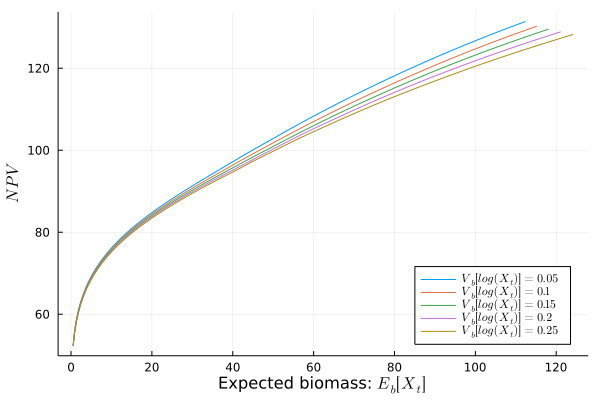

In [416]:
using LaTeXStrings
using Plots
meanNodes = log(0.5):0.005:log(110)
Plots.plot(exp.(meanNodes.+0.5*0.05),broadcast(x->V2([x,0.05]), meanNodes), label = L"V_b[log(X_t)] = 0.05")
Plots.plot!(exp.(meanNodes.+0.5*0.1),broadcast(x->V2([x,0.1]), meanNodes), label = L"V_b[log(X_t)] = 0.1")
Plots.plot!(exp.(meanNodes.+0.5*0.15),broadcast(x->V2([x,0.15]), meanNodes), label = L"V_b[log(X_t)] = 0.15")
Plots.plot!(exp.(meanNodes.+0.5*0.2),broadcast(x->V2([x,0.2]), meanNodes), label = L"V_b[log(X_t)] = 0.2")
Plots.plot!(exp.(meanNodes.+0.5*0.25),broadcast(x->V2([x,0.25]), meanNodes), label = L"V_b[log(X_t)] = 0.25",
            xlab = string("Expected biomass: ", L"E_b[X_t]"), ylab = L"NPV", legend = :bottomright)

In [ ]:
N = grid2.dimsMean
harvest = zeros(N,N)
monitoring = zeros(N,N)
for i in 1:N
    for j in 1:N
        harvest[i,j],monitoring[i,j]=MDPsolver.policy!(zeros(2),i,j,grid2,V2,rewards2,0.9524)
    end 
end 
Plots.heatmap(grid2.nodesVar,exp.(grid2.nodesMean),monitoring)

In [ ]:
sigma = broadcast(i -> reshape(collect(Iterators.product(grid2.nodesMean,grid2.nodesVar)),
                length(grid4.nodesVar)*length(grid2.nodesMean))[i][1], 1:(grid2.dimsMean*grid2.dimsVar))
mu = broadcast(i -> reshape(collect(Iterators.product(grid4.nodesMean,grid4.nodesVar)),
                length(grid4.nodesVar)*length(grid2.nodesMean))[i][2], 1:(grid2.dimsMean*grid2.dimsVar))
value = reshape(monitoring,length(grid4.nodesVar)*length(grid4.nodesMean))

dat = hcat(hcat(sigma,mu),value)

using DelimitedFiles

writedlm( "data/monitoring_P2.csv",  dat, ',')

In [ ]:
N = grid2.dimsMean
Plots.plot(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[1]),
                broadcast(x->MDPsolver.policy!(zeros(2),x,1,grid2,V2,rewards2,0.9524)[1], 1:N),
               label = L"V_b[log(X_t)] = 0.001")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[25]),
            broadcast(x->MDPsolver.policy!(zeros(2),x,25,grid2,V2,rewards2,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.07")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[50]),
            broadcast(x->MDPsolver.policy!(zeros(2),x,50,grid2,V2,rewards2,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.14")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[75]),
            broadcast(x->MDPsolver.policy!(zeros(2),x,75,grid2,V2,rewards2,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.22",
            xlab = string("Expected biomass: ", L"E_b[X_t]"), ylab = L"\hat{H}_t",
                legend =:bottomright)

In [ ]:
Plots.plot(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[1]),
                exp.(grid2.nodesMean.+0.5*grid2.nodesVar[1]) .- broadcast(x->MDPsolver.policy!(zeros(2),x,1,grid2,V2,rewards2,0.9524)[1], 1:N),
               label = L"V_b[log(X_t)] = 0.001")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[25]),
            exp.(grid2.nodesMean.+0.5*grid2.nodesVar[25]).-broadcast(x->MDPsolver.policy!(zeros(2),x,25,grid2,V2,rewards2,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.07")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[50]),
            exp.(grid2.nodesMean.+0.5*grid2.nodesVar[50]).-broadcast(x->MDPsolver.policy!(zeros(2),x,50,grid2,V2,rewards2,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.14")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[75]),
            exp.(grid2.nodesMean.+0.5*grid2.nodesVar[75]).-broadcast(x->MDPsolver.policy!(zeros(2),x,75,grid2,V2,rewards2,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.22",
            xlab = string("Expected biomass: ", L"E_b[X_t]"), ylab = "Expected Escapement",
                legend =:bottomright)
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[75]),exp.(grid2.nodesMean.+0.5*grid2.nodesVar[75]),
color = "black", linestyle = :dash, label ="", xlims = (0,100), ylims = (0,100))

# Risk neutral

In [ ]:

R3 = (x,actions,ct) -> SurplusProduction.R(x,actions,ct,0.0,0.00,1.5)

V3 = MDPsolver.ValueFunctions.init_Norm2DGrid(log(Bmax),log(Bmin),log(CVmax^2+1),N)

rewards3 = BeliefStateTransitions.init_rewards(R3,model2,V3)
BeliefStateTransitions.computeRewards!(rewards3)

MDPsolver.solve_parallel(grid2,V3,rewards3,1/(1+0.05); threashold=10^-3)

In [ ]:
using LaTeXStrings
using Plots
meanNodes = log(0.5):0.005:log(110)
Plots.plot(exp.(meanNodes.+0.5*0.05),broadcast(x->V3([x,0.05]), meanNodes), label = L"V_b[log(X_t)] = 0.05")
Plots.plot!(exp.(meanNodes.+0.5*0.1),broadcast(x->V3([x,0.1]), meanNodes), label = L"V_b[log(X_t)] = 0.1")
Plots.plot!(exp.(meanNodes.+0.5*0.15),broadcast(x->V3([x,0.15]), meanNodes), label = L"V_b[log(X_t)] = 0.15")
Plots.plot!(exp.(meanNodes.+0.5*0.2),broadcast(x->V3([x,0.2]), meanNodes), label = L"V_b[log(X_t)] = 0.2")
Plots.plot!(exp.(meanNodes.+0.5*0.25),broadcast(x->V3([x,0.25]), meanNodes), label = L"V_b[log(X_t)] = 0.25",
            xlab = string("Expected biomass: ", L"E_b[X_t]"), ylab = L"NPV", legend = :bottomright)

In [ ]:

N = grid2.dimsMean
harvest = zeros(N,N)
monitoring = zeros(N,N)
for i in 1:N
    for j in 1:N
        harvest[i,j],monitoring[i,j]=MDPsolver.policy!(zeros(2),i,j,grid2,V3,rewards3,0.9524)
    end 
end 
Plots.heatmap(grid2.nodesVar,exp.(grid2.nodesMean),monitoring)

In [ ]:
sigma = broadcast(i -> reshape(collect(Iterators.product(grid2.nodesMean,grid2.nodesVar)),
                length(grid4.nodesVar)*length(grid2.nodesMean))[i][1], 1:(grid2.dimsMean*grid2.dimsVar))
mu = broadcast(i -> reshape(collect(Iterators.product(grid4.nodesMean,grid4.nodesVar)),
                length(grid4.nodesVar)*length(grid2.nodesMean))[i][2], 1:(grid2.dimsMean*grid2.dimsVar))
value = reshape(monitoring,length(grid4.nodesVar)*length(grid4.nodesMean))

dat = hcat(hcat(sigma,mu),value)

using DelimitedFiles

writedlm( "data/monitoring_P3.csv",  dat, ',')

In [ ]:
Plots.plot(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[1]),
                broadcast(x->MDPsolver.policy!(zeros(2),x,1,grid2,V3,rewards3,0.9524)[1], 1:N),
               label = L"V_b[log(X_t)] = 0.001")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[25]),
            broadcast(x->MDPsolver.policy!(zeros(2),x,25,grid2,V3,rewards3,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.07")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[50]),
            broadcast(x->MDPsolver.policy!(zeros(2),x,50,grid2,V3,rewards3,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.14")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[75]),
            broadcast(x->MDPsolver.policy!(zeros(2),x,75,grid2,V3,rewards3,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.22",
            xlab = string("Expected biomass: ", L"E_b[X_t]"), ylab = L"\hat{H}_t",
                legend =:bottomright)

In [ ]:
Plots.plot(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[1]),
                exp.(grid2.nodesMean.+0.5*grid2.nodesVar[1]).-broadcast(x->MDPsolver.policy!(zeros(2),x,1,grid2,V3,rewards3,0.9524)[1], 1:N),
               label = L"V_b[log(X_t)] = 0.001")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[25]),
            exp.(grid2.nodesMean.+0.5*grid2.nodesVar[25]).-broadcast(x->MDPsolver.policy!(zeros(2),x,25,grid2,V3,rewards3,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.07")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[50]),
            exp.(grid2.nodesMean.+0.5*grid2.nodesVar[50]).-broadcast(x->MDPsolver.policy!(zeros(2),x,50,grid2,V3,rewards3,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.14")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[75]),
            exp.(grid2.nodesMean.+0.5*grid2.nodesVar[75]).-broadcast(x->MDPsolver.policy!(zeros(2),x,75,grid2,V3,rewards3,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.22",
            xlab = string("Expected biomass: ", L"E_b[X_t]"), ylab = "Expected Escapement",
                legend =:bottomright)
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[75]),exp.(grid2.nodesMean.+0.5*grid2.nodesVar[75]),
color = "black", linestyle = :dash, label ="", xlims = (0,100), ylims = (0,100))


# Strong risk aversion 

In [ ]:
R4 = (x,actions,ct) -> SurplusProduction.R_log(x,actions,ct,0.0,0.00,0.15)

V4 = MDPsolver.ValueFunctions.init_Norm2DGrid(log(Bmax),log(Bmin),log(CVmax^2+1),N)

rewards4= BeliefStateTransitions.init_rewards(R4,model2,V4)
BeliefStateTransitions.computeRewards!(rewards4)

MDPsolver.solve_parallel(grid2,V4,rewards4,1/(1+0.05); threashold=10^-3)

In [ ]:
using LaTeXStrings
using Plots
meanNodes = log(0.5):0.005:log(110)
Plots.plot(exp.(meanNodes.+0.5*0.05),broadcast(x->V4([x,0.05]), meanNodes), label = L"V_b[log(X_t)] = 0.05")
Plots.plot!(exp.(meanNodes.+0.5*0.1),broadcast(x->V4([x,0.1]), meanNodes), label = L"V_b[log(X_t)] = 0.1")
Plots.plot!(exp.(meanNodes.+0.5*0.15),broadcast(x->V4([x,0.15]), meanNodes), label = L"V_b[log(X_t)] = 0.15")
Plots.plot!(exp.(meanNodes.+0.5*0.2),broadcast(x->V4([x,0.2]), meanNodes), label = L"V_b[log(X_t)] = 0.2")
Plots.plot!(exp.(meanNodes.+0.5*0.25),broadcast(x->V4([x,0.25]), meanNodes), label = L"V_b[log(X_t)] = 0.25",
            xlab = string("Expected biomass: ", L"E_b[X_t]"), ylab = L"NPV", legend = :bottomright)

In [ ]:
N = grid2.dimsMean
harvest = zeros(N,N)
monitoring = zeros(N,N)
for i in 1:N
    for j in 1:N
        harvest[i,j],monitoring[i,j]=MDPsolver.policy!(zeros(2),i,j,grid2,V4,rewards4,0.9524)
    end 
end 
Plots.heatmap(grid2.nodesVar,exp.(grid2.nodesMean),monitoring)

In [ ]:
sigma = broadcast(i -> reshape(collect(Iterators.product(grid2.nodesMean,grid2.nodesVar)),
                length(grid4.nodesVar)*length(grid2.nodesMean))[i][1], 1:(grid2.dimsMean*grid2.dimsVar))
mu = broadcast(i -> reshape(collect(Iterators.product(grid4.nodesMean,grid4.nodesVar)),
                length(grid4.nodesVar)*length(grid2.nodesMean))[i][2], 1:(grid2.dimsMean*grid2.dimsVar))
value = reshape(monitoring,length(grid4.nodesVar)*length(grid4.nodesMean))

dat = hcat(hcat(sigma,mu),value)

using DelimitedFiles

writedlm( "data/monitoring_P4.csv",  dat, ',')

In [ ]:
Plots.plot(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[1]),
                broadcast(x->MDPsolver.policy!(zeros(2),x,1,grid2,V4,rewards4,0.9524)[1], 1:N),
               label = L"V_b[log(X_t)] = 0.001")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[25]),
            broadcast(x->MDPsolver.policy!(zeros(2),x,25,grid2,V4,rewards4,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.07")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[50]),
            broadcast(x->MDPsolver.policy!(zeros(2),x,50,grid2,V4,rewards4,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.14")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[75]),
            broadcast(x->MDPsolver.policy!(zeros(2),x,75,grid2,V4,rewards4,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.22",
            xlab = string("Expected biomass: ", L"E_b[X_t]"), ylab = L"\hat{H}_t",
                legend =:bottomright)

In [ ]:
Plots.plot(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[1]),
                exp.(grid2.nodesMean.+0.5*grid2.nodesVar[1]).-broadcast(x->MDPsolver.policy!(zeros(2),x,1,grid2,V4,rewards4,0.9524)[1], 1:N),
               label = L"V_b[log(X_t)] = 0.001")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[25]),
            exp.(grid2.nodesMean.+0.5*grid2.nodesVar[25]).-broadcast(x->MDPsolver.policy!(zeros(2),x,25,grid2,V4,rewards4,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.07")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[50]),
            exp.(grid2.nodesMean.+0.5*grid2.nodesVar[50]).-broadcast(x->MDPsolver.policy!(zeros(2),x,50,grid2,V4,rewards4,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.14")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[75]),
            exp.(grid2.nodesMean.+0.5*grid2.nodesVar[75]).-broadcast(x->MDPsolver.policy!(zeros(2),x,75,grid2,V4,rewards4,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.22",
            xlab = string("Expected biomass: ", L"E_b[X_t]"), ylab = "Expected Escapement",
                legend =:bottomright)
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[75]),exp.(grid2.nodesMean.+0.5*grid2.nodesVar[75]),
color = "black", linestyle = :dash, label ="", xlims = (0,100), ylims = (0,100))

# Alee effects 

In [ ]:
params = SurplusProduction.reparam(10,0.2)

params = (100,10,params[1],params[2])


T = (x,actions,aux) -> SurplusProduction.Bt_alee_alt(x,actions,aux,params)
SigmaN = [0.075;;]


# set observations model
H = [1.0;;]
function SigmaO(actions,aux)
    Ht,obs=actions
    Sigma_O = zeros(1,1)
    if obs == 1
        Sigma_O[1,1] = 0.1
    else
        Sigma_O[1,1] = 1.5
    end
    return Sigma_O
end 

# Set grid for harvest rates and monitoring levels
harvest = collect(0.0:2.5:50)
observations = [0,1]
actions = reshape(collect(Iterators.product(harvest, observations)), length(harvest)*length(observations))
        
# define model object to compute grid 
model6=BeliefStateTransitions.init_model(T,H,actions,SigmaO,SigmaN)  

# Define value function 
Bmax = 150.0
Bmin = 1.0
N = 75
CVmax = 0.75
V = ValueFunctions.init_Norm2DGrid(log(Bmax),log(Bmin),log(CVmax^2+1),N)

# define grid 
mQuad = 15
grid6=BeliefStateTransitions.init_transitions("quadrature",model6,V;mQuad = mQuad)

BeliefStateTransitions.computeTransitions!(grid6)
@save "data/grid_6.jld2" grid6

In [ ]:
R9 = (x,actions,ct) -> SurplusProduction.R_log(x,actions,ct,0.0,0.00,0.25)

V9 = MDPsolver.ValueFunctions.init_Norm2DGrid(log(Bmax),log(Bmin),log(CVmax^2+1),N)

rewards9= BeliefStateTransitions.init_rewards(R9,model6,V9)
BeliefStateTransitions.computeRewards!(rewards9)

MDPsolver.solve_parallel(grid6,V9,rewards9,1/(1+0.05); threashold=10^-3)

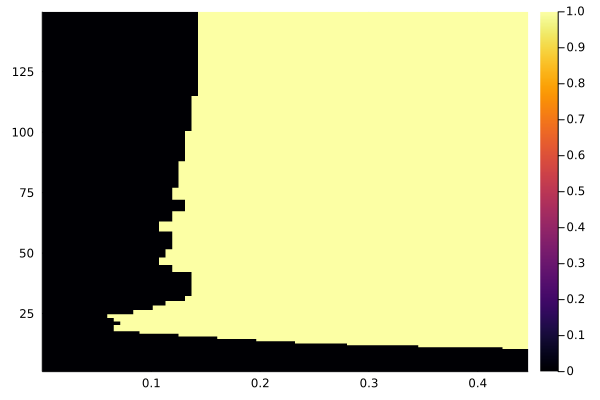

In [246]:
N = grid2.dimsMean
harvest = zeros(N,N)
monitoring = zeros(N,N)
for i in 1:N
    for j in 1:N
        harvest[i,j],monitoring[i,j]=MDPsolver.policy!(zeros(2),i,j,grid6,V9,rewards9,0.9524)
    end 
end 
Plots.heatmap(grid6.nodesVar,exp.(grid6.nodesMean),monitoring)

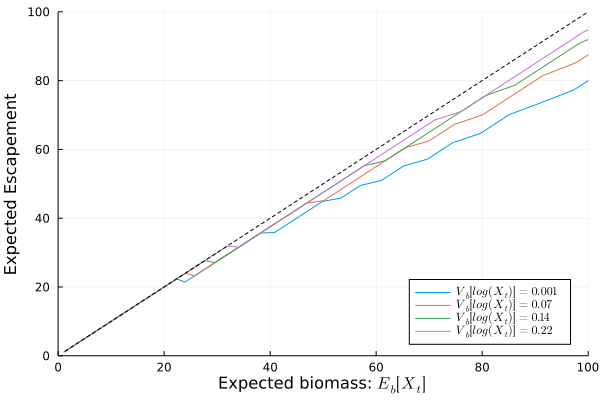

In [247]:
Plots.plot(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[1]),
                exp.(grid2.nodesMean.+0.5*grid2.nodesVar[1]).-broadcast(x->MDPsolver.policy!(zeros(2),x,1,grid6,V9,rewards9,0.9524)[1], 1:N),
               label = L"V_b[log(X_t)] = 0.001")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[25]),
            exp.(grid2.nodesMean.+0.5*grid2.nodesVar[25]).-broadcast(x->MDPsolver.policy!(zeros(2),x,25,grid6,V9,rewards9,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.07")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[50]),
            exp.(grid2.nodesMean.+0.5*grid2.nodesVar[50]).-broadcast(x->MDPsolver.policy!(zeros(2),x,50,grid6,V9,rewards9,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.14")
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[75]),
            exp.(grid2.nodesMean.+0.5*grid2.nodesVar[75]).-broadcast(x->MDPsolver.policy!(zeros(2),x,75,grid6,V9,rewards9,0.9524)[1], 1:N), 
            label = L"V_b[log(X_t)] = 0.22",
            xlab = string("Expected biomass: ", L"E_b[X_t]"), ylab = "Expected Escapement",
                legend =:bottomright)
Plots.plot!(exp.(grid2.nodesMean.+0.5*grid2.nodesVar[75]),exp.(grid2.nodesMean.+0.5*grid2.nodesVar[75]),
color = "black", linestyle = :dash, label ="", xlims = (0,100), ylims = (0,100))

# Probability based control rule ($p^* - \sigma$)

In [35]:
params = SurplusProduction.reparam(10,0.2)
T = (x,actions,aux) -> SurplusProduction.Bt_alt_pstar(x,actions,aux,params)
SigmaN = [0.05;;]

# pstar sigma
Fmin = 0.02
Fmax = 0.2
Bmin = 0.0
Bcrit = 0.0
Hmax = 200
aux = state -> SurplusProduction.pstar_sigma(0.4,state,(Bmin,Bcrit,Fmin,Fmax),Hmax)

# new observation model 
function SigmaO(actions,aux)
    Sigma_O = zeros(1,1)
    if actions == 1
        Sigma_O[1,1] = 0.1
    else
        Sigma_O[1,1] = 1.5
    end
    return Sigma_O
end 

# define model object to compute grid 
actions = [0,1]
model3=BeliefStateTransitions.init_model(T,aux,H,actions,SigmaO,SigmaN)  


# Define value function 
Bmax = 150.0
Bmin = 0.1
N = 100
CVmax = 0.75
V = ValueFunctions.init_Norm2DGrid(log(Bmax),log(Bmin),log(CVmax^2+1),N)


# value function and grid 
grid3=BeliefStateTransitions.init_transitions("quadrature",model3,V;mQuad = mQuad)

using JLD2
BeliefStateTransitions.computeTransitions!(grid3)
@save "data/grid_3.jld2" grid3

┌ Info:  started timer at: 2022-11-10T08:21:20.684
└ @ TickTock /Users/johnbuckner/.julia/packages/TickTock/fGILW/src/TickTock.jl:54


progress = 5.0%  time: 3.0
progress = 10.0%  time: 3.0
progress = 15.0%  time: 3.0
progress = 20.0%  time: 3.0
progress = 25.0%  time: 3.0
progress = 30.0%  time: 3.0
progress = 35.0%  time: 3.0
progress = 40.0%  time: 3.0
progress = 45.0%  time: 3.0
progress = 50.0%  time: 3.0
progress = 55.0%  time: 3.0
progress = 60.0%  time: 3.0
progress = 65.0%  time: 4.0
progress = 70.0%  time: 4.0
progress = 75.0%  time: 4.0
progress = 80.0%  time: 4.0
progress = 85.0%  time: 4.0
progress = 90.0%  time: 4.0
progress = 95.0%  time: 4.0
progress = 100.0%  time: 4.0


In [ ]:
include("../src/ValueFunctions.jl")
include("../src/BeliefStateTransitions.jl")
include("SurplusProduction.jl")
include("../src/MDPsolver.jl")

R5 = (x,actions,aux) -> SurplusProduction.Rpstar(x,actions,aux,10.0,0.0085,1.5) #10.0,0.0085,1.5 

rewards5 = BeliefStateTransitions.init_rewards(R5,model3,V)
BeliefStateTransitions.computeRewards!(rewards5)

V5 = MDPsolver.ValueFunctions.init_Norm2DGrid(log(Bmax),log(Bmin),log(CVmax^2+1),N)
print(" ")

MDPsolver.solve_parallel(grid3,V5,rewards5,0.9524)

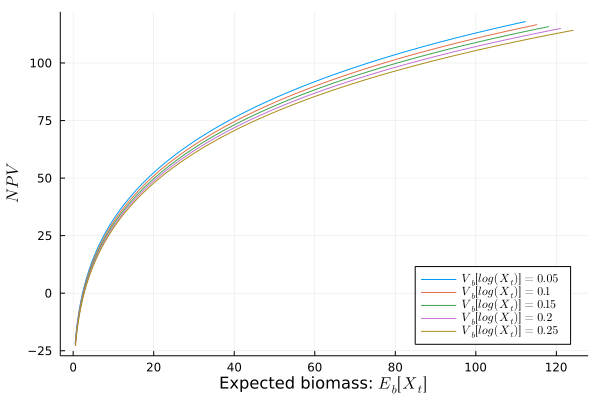

In [595]:
meanNodes = log(0.5):0.005:log(110)
Plots.plot(exp.(meanNodes.+0.5*0.05),broadcast(x->V5([x,0.05]), meanNodes), label = L"V_b[log(X_t)] = 0.05")
Plots.plot!(exp.(meanNodes.+0.5*0.1),broadcast(x->V5([x,0.1]), meanNodes), label = L"V_b[log(X_t)] = 0.1")
Plots.plot!(exp.(meanNodes.+0.5*0.15),broadcast(x->V5([x,0.15]), meanNodes), label = L"V_b[log(X_t)] = 0.15")
Plots.plot!(exp.(meanNodes.+0.5*0.2),broadcast(x->V5([x,0.2]), meanNodes), label = L"V_b[log(X_t)] = 0.2")
Plots.plot!(exp.(meanNodes.+0.5*0.25),broadcast(x->V5([x,0.25]), meanNodes), label = L"V_b[log(X_t)] = 0.25",
            xlab = string("Expected biomass: ", L"E_b[X_t]"), ylab = L"NPV", legend = :bottomright)

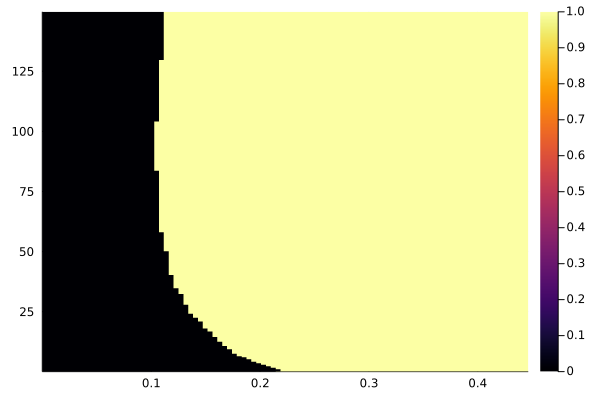

In [596]:
#include("../src/MDPsolver.jl")
monitoring = zeros(N,N)
for i in 1:N
    for j in 1:N
        monitoring[i,j]=MDPsolver.policy!(zeros(2),i,j,grid3,V5,rewards5,0.9524)
    end 
end 
p = Plots.heatmap(grid3.nodesVar,exp.(grid3.nodesMean),monitoring)

sigma = broadcast(i -> reshape(collect(Iterators.product(grid3.nodesMean,grid3.nodesVar)),
                length(grid3.nodesVar)*length(grid3.nodesMean))[i][1], 1:(grid3.dimsMean*grid3.dimsVar))
mu = broadcast(i -> reshape(collect(Iterators.product(grid3.nodesMean,grid3.nodesVar)),
                length(grid3.nodesVar)*length(grid3.nodesMean))[i][2], 1:(grid3.dimsMean*grid3.dimsVar))
value = reshape(monitoring,length(grid3.nodesVar)*length(grid3.nodesMean))

dat = hcat(hcat(sigma,mu),value)

using DelimitedFiles

writedlm( "data/monitoring_P5.csv",  dat, ',')
p

# risk averse 

In [2]:
include("../src/ValueFunctions.jl")
include("../src/BeliefStateTransitions.jl")
include("SurplusProduction.jl")
include("../src/MDPsolver.jl")

R6 = (x,actions,aux) -> SurplusProduction.Rpstar_log(x,actions,aux,0.0,0.00,0.1) 

rewards6 = BeliefStateTransitions.init_rewards(R6,model3,V)
BeliefStateTransitions.computeRewards!(rewards6)

V6 = MDPsolver.ValueFunctions.init_Norm2DGrid(log(Bmax),log(Bmin),log(CVmax^2+1),N)
print(" ")

MDPsolver.solve_parallel(grid3,V6,rewards6,0.9524)

LoadError: UndefVarError: model3 not defined

In [ ]:
meanNodes = log(0.5):0.005:log(110)
Plots.plot(exp.(meanNodes.+0.5*0.05),broadcast(x->V6([x,0.05]), meanNodes), label = L"V_b[log(X_t)] = 0.05")
Plots.plot!(exp.(meanNodes.+0.5*0.1),broadcast(x->V6([x,0.1]), meanNodes), label = L"V_b[log(X_t)] = 0.1")
Plots.plot!(exp.(meanNodes.+0.5*0.15),broadcast(x->V6([x,0.15]), meanNodes), label = L"V_b[log(X_t)] = 0.15")
Plots.plot!(exp.(meanNodes.+0.5*0.2),broadcast(x->V6([x,0.2]), meanNodes), label = L"V_b[log(X_t)] = 0.2")
Plots.plot!(exp.(meanNodes.+0.5*0.25),broadcast(x->V6([x,0.25]), meanNodes), label = L"V_b[log(X_t)] = 0.25",
            xlab = string("Expected biomass: ", L"E_b[X_t]"), ylab = L"NPV", legend = :bottomright)

In [ ]:
include("../src/MDPsolver.jl")
N = 75
monitoring = zeros(N,N)
for i in 1:N
    for j in 1:N
        monitoring[i,j]=MDPsolver.policy!(zeros(2),i,j,grid3,V6,rewards6,0.9524)
    end 
end 
Plots.heatmap(grid3.nodesVar,exp.(grid3.nodesMean),monitoring)

In [ ]:
sigma = broadcast(i -> reshape(collect(Iterators.product(grid2.nodesMean,grid2.nodesVar)),
                length(grid4.nodesVar)*length(grid2.nodesMean))[i][1], 1:(grid2.dimsMean*grid2.dimsVar))
mu = broadcast(i -> reshape(collect(Iterators.product(grid4.nodesMean,grid4.nodesVar)),
                length(grid4.nodesVar)*length(grid2.nodesMean))[i][2], 1:(grid2.dimsMean*grid2.dimsVar))
value = reshape(monitoring,length(grid4.nodesVar)*length(grid4.nodesMean))

dat = hcat(hcat(sigma,mu),value)

using DelimitedFiles

writedlm( "data/monitoring_P6.csv",  dat, ',')

# Probability based 40-10 rule 

In [3]:
params = SurplusProduction.reparam(10,0.2)
T = (x,actions,aux) -> SurplusProduction.Bt_alt_pstar(x,actions,aux,params)
SigmaN = [0.05;;]

# pstar sigma
Fmin = 0.02
Fmax = 0.2
Bmin = 11.0 # 10% Binf
Bcrit = 44.0  # 40% Binf
Hmax = 200
pstar = 0.4
aux = state -> SurplusProduction.pstar_sigma(pstar,state,(Bmin,Bcrit,Fmin,Fmax),Hmax)

# new observation model 
H = [1.0;;]
function SigmaO(actions,aux)
    Sigma_O = zeros(1,1)
    if actions == 1
        Sigma_O[1,1] = 0.1
    else
        Sigma_O[1,1] = 1.5
    end
    return Sigma_O
end 

# define model object to compute grid 
actions = [0,1]
model=BeliefStateTransitions.init_model(T,aux,H,actions,SigmaO,SigmaN)  


# Define value function 
Bmax = 150.0
Bmin = 0.1
N = 100
CVmax = 0.75
V = ValueFunctions.init_Norm2DGrid(log(Bmax),log(Bmin),log(CVmax^2+1),N)


# value function and grid 
grid5=BeliefStateTransitions.init_transitions("quadrature",model,V;mQuad = 50)

using JLD2
BeliefStateTransitions.computeTransitions!(grid5)
@save "data/grid_5.jld2" grid5

LoadError: MethodError: no method matching init_model(::var"#3#4", ::var"#5#6", ::Matrix{Float64}, ::Vector{Int64}, ::typeof(SigmaO), ::Matrix{Float64})
[0mClosest candidates are:
[0m  init_model(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, [91m::Any[39m) at ~/github/KalmanFilterPOMDPs/src/BeliefStateTransitions.jl:25
[0m  init_model(::Any, ::Any, ::Any, ::Any, ::Any) at ~/github/KalmanFilterPOMDPs/src/BeliefStateTransitions.jl:34

In [ ]:
include("../src/ValueFunctions.jl")
include("../src/BeliefStateTransitions.jl")
include("SurplusProduction.jl")
include("../src/MDPsolver.jl")

R8 = (x,actions,aux) -> SurplusProduction.Rpstar(x,actions,aux,10.0,0.0085,1.5) # 

rewards8 = BeliefStateTransitions.init_rewards(R8,model5,V)
BeliefStateTransitions.computeRewards!(rewards8)

V8 = MDPsolver.ValueFunctions.init_Norm2DGrid(log(Bmax),log(Bmin),log(CVmax^2+1),N)
print(" ")

MDPsolver.solve_parallel(grid5,V8,rewards8,0.9524)

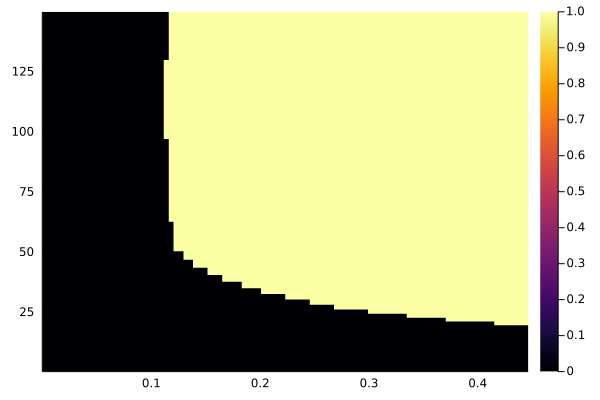

In [604]:
N = 100
monitoring = zeros(N,N)
for i in 1:N
    for j in 1:N
        monitoring[i,j]=MDPsolver.policy!(zeros(2),i,j,grid5,V8,rewards8,0.9524)
    end 
end 
Plots.heatmap(grid5.nodesVar,exp.(grid5.nodesMean),monitoring)

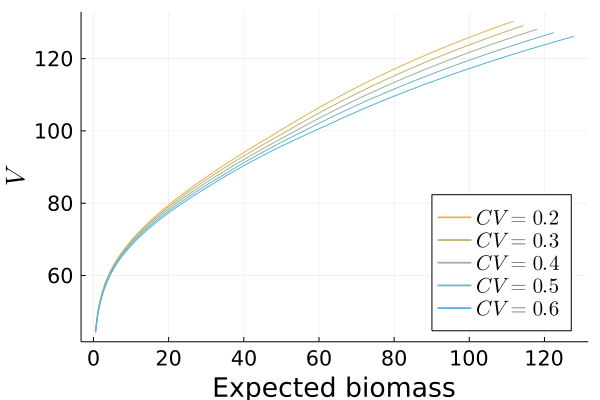

In [605]:
using Colors
sigma = [0.039, 0.0862,0.148,0.223, 0.3075]

meanNodes = log(0.5):0.005:log(110)
p1 = Plots.plot(exp.(meanNodes.+0.5*sigma[1]),broadcast(x->V8([x,sigma[1]]), meanNodes), label = L"CV = 0.2",
            c = Colors.RGB(0.9,0.7,0.3))
Plots.plot!(exp.(meanNodes.+0.5*sigma[2]),broadcast(x->V8([x,sigma[2]]), meanNodes), label = L"CV = 0.3",
            c = Colors.RGB(0.75,0.7,0.45))
Plots.plot!(exp.(meanNodes.+0.5*sigma[3]),broadcast(x->V8([x,sigma[3]]), meanNodes), label = L"CV = 0.4",
            c = Colors.RGB(0.6,0.7,0.6))
Plots.plot!(exp.(meanNodes.+0.5*sigma[4]),broadcast(x->V8([x,sigma[4]]), meanNodes), label = L"CV = 0.5",
            c = Colors.RGB(0.45,0.7,0.75))
Plots.plot!(exp.(meanNodes.+0.5*sigma[5]),broadcast(x->V8([x,sigma[5]]), meanNodes), label = L"CV = 0.6",
            c = Colors.RGB(0.3,0.7,0.9),xlab = "Expected biomass", ylab = L"V", 
            legend = :bottomright,tickfontsize = 14,guidefontsize=18,legendfontsize=14)
savefig("figures/V_functions_base_40_10.png")
p1

In [606]:
include("../src/MDPsolver.jl")
N = 100
monitoring = zeros(N,N)
for i in 1:N
    for j in 1:N
        monitoring[i,j]=MDPsolver.policy!(zeros(2),i,j,grid5,V8,rewards8,0.9524)
    end 
end 
p = Plots.heatmap(grid5.nodesVar,exp.(grid5.nodesMean),monitoring)

sigma = broadcast(i -> reshape(collect(Iterators.product(grid5.nodesMean,grid5.nodesVar)),
                length(grid5.nodesVar)*length(grid5.nodesMean))[i][1], 1:(grid5.dimsMean*grid5.dimsVar))
mu = broadcast(i -> reshape(collect(Iterators.product(grid5.nodesMean,grid5.nodesVar)),
                length(grid5.nodesVar)*length(grid5.nodesMean))[i][2], 1:(grid5.dimsMean*grid5.dimsVar))
value = reshape(monitoring,length(grid5.nodesVar)*length(grid5.nodesMean))

dat = hcat(hcat(sigma,mu),value)

using DelimitedFiles

writedlm( "data/monitoring_P8.csv",  dat, ',')


# risk averse + 40-10 rule

In [ ]:
include("../src/ValueFunctions.jl")
include("../src/BeliefStateTransitions.jl")
include("SurplusProduction.jl")
include("../src/MDPsolver.jl")

R9 = (x,actions,aux) -> SurplusProduction.Rpstar_log(x,actions,aux,0.0,0.0,0.1) 

rewards9 = BeliefStateTransitions.init_rewards(R9,model5,V)
BeliefStateTransitions.computeRewards!(rewards9)

V9 = MDPsolver.ValueFunctions.init_Norm2DGrid(log(Bmax),log(Bmin),log(CVmax^2+1),N)
print(" ")

MDPsolver.solve_parallel(grid5,V9,rewards9,0.9524)

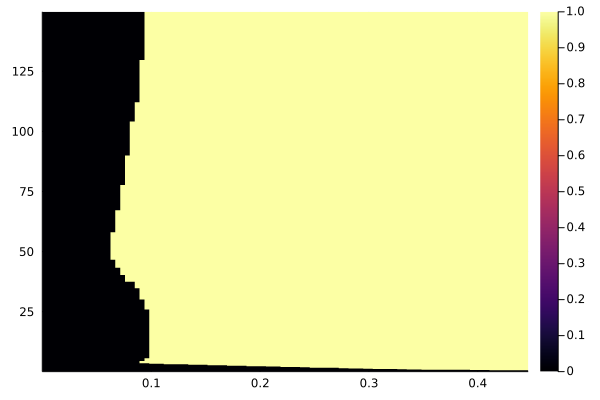

In [400]:
N = 100
monitoring = zeros(N,N)
for i in 1:N
    for j in 1:N
        monitoring[i,j]=MDPsolver.policy!(zeros(2),i,j,grid5,V9,rewards9,0.9524)
    end 
end 
Plots.heatmap(grid5.nodesVar,exp.(grid5.nodesMean),monitoring)

# 40-10 + non use values 

Setting $F_{target} < F_{MSY}$ 

In [202]:
Fm
params = SurplusProduction.reparam(10,0.2)
T = (x,actions,aux) -> SurplusProduction.Bt_alt_pstar(x,actions,aux,params,Fm)
SigmaN = [0.05;;]

# pstar sigma
Fmin = 0.02
Fmax = 0.2
Bmin = 11.0 # 10% Binf
Bcrit = 44.0  # 40% Binf
Hmax = 200
pstar = 0.4
aux = state -> SurplusProduction.pstar_sigma(pstar,state,(Bmin,Bcrit,Fmin,Fmax),Hmax)

# new observation model 
H = [1.0;;]
function SigmaO(actions,aux)
    Sigma_O = zeros(1,1)
    if actions == 1
        Sigma_O[1,1] = 0.1
    else
        Sigma_O[1,1] = 1.5
    end
    return Sigma_O
end 

# define model object to compute grid 
actions = [0,1]
model=BeliefStateTransitions.init_model(T,aux,H,actions,SigmaO,SigmaN)  


# Define value function 
Bmax = 150.0
Bmin = 0.1
N = 100
CVmax = 0.75
V = ValueFunctions.init_Norm2DGrid(log(Bmax),log(Bmin),log(CVmax^2+1),N)


# value function and grid 
grid5=BeliefStateTransitions.init_transitions("quadrature",model,V;mQuad = 50)
BeliefStateTransitions.computeTransitions!(grid5)
print(" ")

┌ Info:  started timer at: 2022-11-11T10:22:11.506
└ @ TickTock /Users/johnbuckner/.julia/packages/TickTock/fGILW/src/TickTock.jl:54


progress = 5.0%  time: 3.0
progress = 10.0%  time: 3.0
progress = 15.0%  time: 3.0
progress = 20.0%  time: 4.0
progress = 25.0%  time: 4.0
progress = 30.0%  time: 4.0
progress = 35.0%  time: 4.0
progress = 40.0%  time: 4.0
progress = 45.0%  time: 5.0
progress = 50.0%  time: 5.0
progress = 55.0%  time: 5.0
progress = 60.0%  time: 5.0
progress = 65.0%  time: 5.0
progress = 70.0%  time: 5.0
progress = 75.0%  time: 6.0
progress = 80.0%  time: 6.0
progress = 85.0%  time: 6.0
progress = 90.0%  time: 6.0
progress = 95.0%  time: 6.0
progress = 100.0%  time: 7.0
 

In [ ]:
include("../src/ValueFunctions.jl")
include("../src/BeliefStateTransitions.jl")
include("SurplusProduction.jl")
include("../src/MDPsolver.jl")


c1 = 10.0
c2 = 0.0085
c3 = 1.5
mV0 = 0.5
maxV = 25
R10 = (x,actions,aux) -> SurplusProduction.Rpstar_nonuse(x,actions,aux,c1,c2,c3,mV0,maxV)

rewards10 = BeliefStateTransitions.init_rewards(R10,model,V)
BeliefStateTransitions.computeRewards!(rewards10)

V10 = MDPsolver.ValueFunctions.init_Norm2DGrid(log(Bmax),log(Bmin),log(CVmax^2+1),N)
print(" ")

MDPsolver.solve_parallel(grid5,V10,rewards10,0.9524;threashold=10^-4)

In [217]:
using Plots
using LaTeXStrings

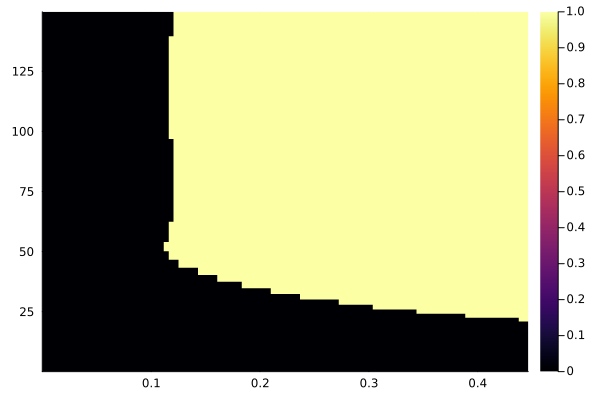

In [218]:
N = 100
monitoring = zeros(N,N)
for i in 1:N
    for j in 1:N
        monitoring[i,j]=MDPsolver.policy!(zeros(2),i,j,grid5,V10,rewards10,0.9524)
    end 
end 
Plots.heatmap(grid5.nodesVar,exp.(grid5.nodesMean),monitoring)

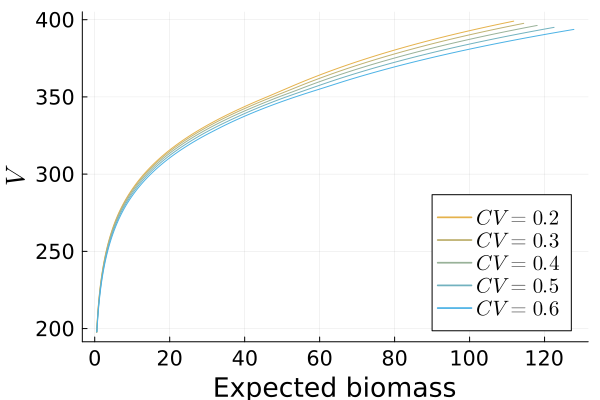

In [215]:
using Colors
sigma = [0.039, 0.0862,0.148,0.223, 0.3075]

meanNodes = log(0.5):0.005:log(110)
p1 = Plots.plot(exp.(meanNodes.+0.5*sigma[1]),broadcast(x->V10([x,sigma[1]]), meanNodes), label = L"CV = 0.2",
            c = Colors.RGB(0.9,0.7,0.3))
Plots.plot!(exp.(meanNodes.+0.5*sigma[2]),broadcast(x->V10([x,sigma[2]]), meanNodes), label = L"CV = 0.3",
            c = Colors.RGB(0.75,0.7,0.45))
Plots.plot!(exp.(meanNodes.+0.5*sigma[3]),broadcast(x->V10([x,sigma[3]]), meanNodes), label = L"CV = 0.4",
            c = Colors.RGB(0.6,0.7,0.6))
Plots.plot!(exp.(meanNodes.+0.5*sigma[4]),broadcast(x->V10([x,sigma[4]]), meanNodes), label = L"CV = 0.5",
            c = Colors.RGB(0.45,0.7,0.75))
Plots.plot!(exp.(meanNodes.+0.5*sigma[5]),broadcast(x->V10([x,sigma[5]]), meanNodes), label = L"CV = 0.6",
            c = Colors.RGB(0.3,0.7,0.9),xlab = "Expected biomass", ylab = L"V", 
            legend = :bottomright,tickfontsize = 14,guidefontsize=18,legendfontsize=14)
savefig("figures/V_functions_base_40_10.png")
p1

# The value of monitring in one period

In [216]:
N = 100
values_1 = zeros(N,N)
values_0 = zeros(N,N)
V_ = zeros(N,N)
for i in 1:N
    for j in 1:N
        values_1[i,j]=MDPsolver.bellman!(zeros(2),2,i,j,grid5,V10,rewards10,0.9524).+ 1.5
        values_0[i,j]=MDPsolver.bellman!(zeros(2),1,i,j,grid5,V10,rewards10,0.9524)
        vals = [values_1[i,j],values_0[i,j]]
        V_[i,j] = vals[argmax(vals)]
    end 
end 

# Define value function 
Bmax = 150.0
Bmin = 0.1
N = 100
CVmax = 0.75
V = ValueFunctions.init_Norm2DGrid(log(Bmax),log(Bmin),log(CVmax^2+1),N)
V.values = reshape(values_1.-values_0, N^2)
ValueFunctions.update1!(V)


print(" ")

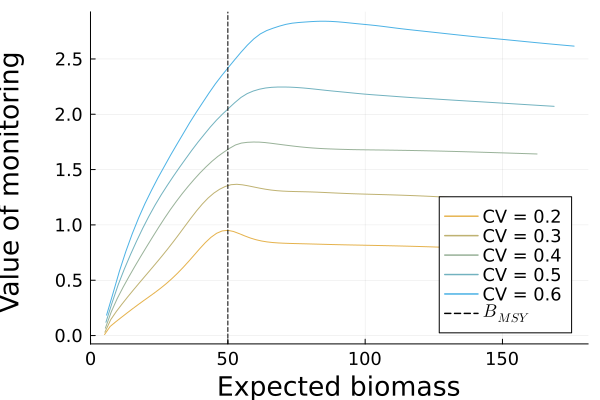

In [208]:
using Roots 
mu = log.(collect(1:2.0:101))
sd1 = 50/8
sd2 = 50/4
sd3 = 50/2
sd4 = 50

sigma = [0.039, 0.0862,0.148,0.223, 0.3075]

var_(x,mu) = sqrt((exp(x^2) - 1)*exp(2*mu + x^2))
sigma_(v,mu) = find_zero(x-> v-var_(x,mu), [0,100])


sd1 = 5.0
mu_sd1 = log.(collect((sd1):2.0:151))
sigma_sd1 = broadcast(x->sigma_(sd1,x), mu_sd1)

mu_sd2 = log.(collect((sd2):2.0:151))
sigma_sd2 = broadcast(x->sigma_(sd2,x), mu_sd2)

mu_sd3 = log.(collect((sd3):2.0:151))
sigma_sd3 = broadcast(x->sigma_(sd3,x), mu_sd3)

mu_sd4 = log.(collect((sd4):2.0:151))
sigma_sd4 = broadcast(x->sigma_(sd4,x), mu_sd4)


p2 = Plots.plot(exp.(mu_sd1 .+ 0.5*sigma[1]),broadcast(i -> V([mu_sd1[i], sigma[1]]), 1:length(mu_sd1)),
label = "CV = 0.2",c = Colors.RGB(0.9,0.7,0.3))
Plots.plot!(exp.(mu_sd1.+ 0.5*sigma[2]),broadcast(i -> V([mu_sd1[i], sigma[2]]), 1:length(mu_sd1)),
label = "CV = 0.3",c = Colors.RGB(0.75,0.7,0.45))
Plots.plot!(exp.(mu_sd1.+ 0.5*sigma[3]),broadcast(i -> V([mu_sd1[i], sigma[3]]), 1:length(mu_sd1)),
label = "CV = 0.4",c = Colors.RGB(0.6,0.7,0.6))
Plots.plot!(exp.(mu_sd1.+ 0.5*sigma[4]),broadcast(i -> V([mu_sd1[i], sigma[4]]), 1:length(mu_sd1)),
label = "CV = 0.5",c = Colors.RGB(0.45,0.7,0.75))
Plots.plot!(exp.(mu_sd1.+ 0.5*sigma[5]),broadcast(i -> V([mu_sd1[i], sigma[5]]), 1:length(mu_sd1)),
label = "CV = 0.6", c = Colors.RGB(0.3,0.7,0.9), xlab = "Expected biomass",
ylab = string("Value of monitoring \n"),
xguidefontsize=18,yguidefontsize=18,xtickfontsize=12,ytickfontsize=12,legendfontsize=12,
legend = :bottomright)
Plots.vline!([50], label = L"B_{MSY}", linestyle = :dash, color = "black")

savefig("figures/Monitroing_Value_base_40_10.png")
p2


# Harvest control rule

In [649]:
# Fising effort 40/ 10 rule 
params = SurplusProduction.reparam(10,0.2)
T = (x,actions,aux) -> SurplusProduction.Bt_alt_pstar(x,actions,aux,params)
SigmaN = [0.05;;]

# pstar sigma
Fmin = 0.02
Fmax = 0.2
Bmin = 11.0 # 10% Binf
Bcrit = 44.0  # 40% Binf
Hmax = 200
pstar = 0.4
aux = state -> SurplusProduction.pstar_sigma(pstar,state,(Bmin,Bcrit,Fmin,Fmax),Hmax)


N = 100
values_1 = zeros(N,N)

for i in 1:N
    for j in 1:N
        values_1[i,j]=aux(([grid5.nodesMean[i]],[grid5.nodesVar[j];;]))
    end 
end 

# Define value function 
Bmax = 150.0
Bmin = 0.1
N = 100
CVmax = 0.75
V = ValueFunctions.init_Norm2DGrid(log(Bmax),log(Bmin),log(CVmax^2+1),N)
V.values = reshape(values_1, N^2)
ValueFunctions.update1!(V)

100×100 extrapolate(interpolate(OffsetArray(::Matrix{Float64}, 0:101, 0:101), BSpline(Cubic(Line(Interpolations.OnCell())))), Line()) with element type Float64:
  0.00204981   0.00203193   0.00201971  …   0.00175372   0.00175223
  0.00220533   0.0021861    0.00217295      0.00188678   0.00188518
  0.00237266   0.00235196   0.00233782      0.00202994   0.00202821
  0.00255268   0.00253041   0.00251519      0.00218395   0.0021821
  0.00274635   0.0027224    0.00270603      0.00234965   0.00234766
  0.00295473   0.00292896   0.00291134  …   0.00252793   0.00252578
  0.00317891   0.00315118   0.00313223      0.00271973   0.00271742
  0.0034201    0.00339027   0.00336988      0.00292608   0.0029236
  0.0036796    0.0036475    0.00362557      0.00314809   0.00314542
  0.00395878   0.00392425   0.00390065      0.00338695   0.00338407
  0.00425914   0.00422199   0.0041966   …   0.00364393   0.00364083
  0.00458229   0.00454232   0.00451501      0.0039204    0.00391707
  0.00492997   0.00488696

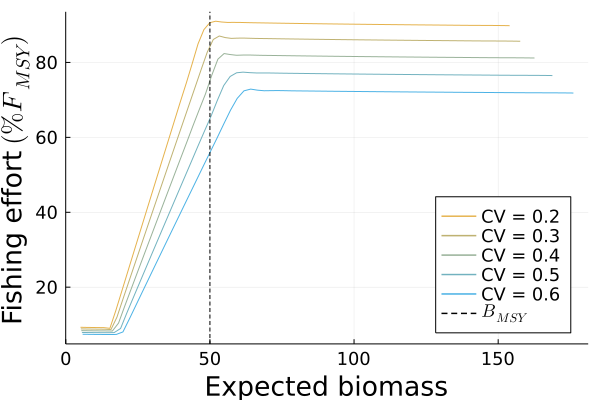

In [645]:

sd1 = 5.0
mu_sd1 = log.(collect((sd1):2.0:151))
sigma_sd1 = broadcast(x->sigma_(sd1,x), mu_sd1)

mu_sd2 = log.(collect((sd2):2.0:151))
sigma_sd2 = broadcast(x->sigma_(sd2,x), mu_sd2)

mu_sd3 = log.(collect((sd3):2.0:151))
sigma_sd3 = broadcast(x->sigma_(sd3,x), mu_sd3)

mu_sd4 = log.(collect((sd4):2.0:151))
sigma_sd4 = broadcast(x->sigma_(sd4,x), mu_sd4)


p2 = Plots.plot(exp.(mu_sd1 .+ 0.5*sigma[1]),
100*broadcast(i -> V([mu_sd1[i], sigma[1]]), 1:length(mu_sd1))./exp.(mu_sd1 .+ 0.5*sigma[1])/0.2,
label = "CV = 0.2",c = Colors.RGB(0.9,0.7,0.3))
Plots.plot!(exp.(mu_sd1.+ 0.5*sigma[2]),
100*broadcast(i -> V([mu_sd1[i], sigma[2]]), 1:length(mu_sd1))./exp.(mu_sd1.+ 0.5*sigma[2])/0.2,
label = "CV = 0.3",c = Colors.RGB(0.75,0.7,0.45))
Plots.plot!(exp.(mu_sd1.+ 0.5*sigma[3]),
100*broadcast(i -> V([mu_sd1[i], sigma[3]]), 1:length(mu_sd1))./exp.(mu_sd1.+ 0.5*sigma[3])/0.2,
label = "CV = 0.4",c = Colors.RGB(0.6,0.7,0.6))
Plots.plot!(exp.(mu_sd1.+ 0.5*sigma[4]),
100*broadcast(i -> V([mu_sd1[i], sigma[4]]), 1:length(mu_sd1))./exp.(mu_sd1.+ 0.5*sigma[4])/0.2,
label = "CV = 0.5",c = Colors.RGB(0.45,0.7,0.75))
Plots.plot!(exp.(mu_sd1.+ 0.5*sigma[5]),
100*broadcast(i -> V([mu_sd1[i], sigma[5]]), 1:length(mu_sd1))./exp.(mu_sd1.+ 0.5*sigma[5])/0.2,
label = "CV = 0.6", c = Colors.RGB(0.3,0.7,0.9), xlab = "Expected biomass",
ylab = string("Fishing effort ", L"(\%F_{MSY})") ,
xguidefontsize=18,yguidefontsize=18,xtickfontsize=12,ytickfontsize=12,legendfontsize=12,
legend = :bottomright)
Plots.vline!([50], label = L"B_{MSY}", linestyle = :dash, color = "black")

savefig("figures/fishing_effort_40_10.png")
p2


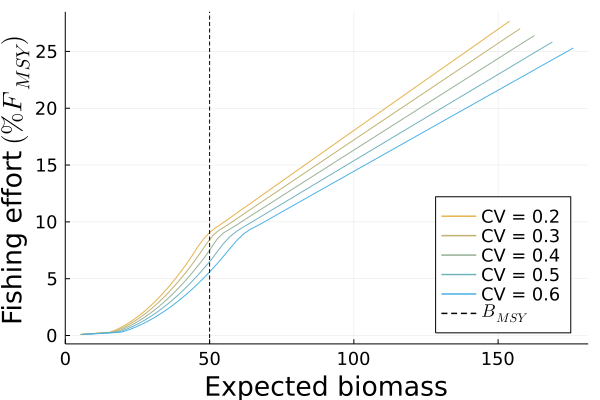

In [650]:
p2 = Plots.plot(exp.(mu_sd1 .+ 0.5*sigma[1]),
broadcast(i -> V([mu_sd1[i], sigma[1]]), 1:length(mu_sd1)),
label = "CV = 0.2",c = Colors.RGB(0.9,0.7,0.3))
Plots.plot!(exp.(mu_sd1.+ 0.5*sigma[2]),
broadcast(i -> V([mu_sd1[i], sigma[2]]), 1:length(mu_sd1)),
label = "CV = 0.3",c = Colors.RGB(0.75,0.7,0.45))
Plots.plot!(exp.(mu_sd1.+ 0.5*sigma[3]),
broadcast(i -> V([mu_sd1[i], sigma[3]]), 1:length(mu_sd1)),
label = "CV = 0.4",c = Colors.RGB(0.6,0.7,0.6))
Plots.plot!(exp.(mu_sd1.+ 0.5*sigma[4]),
broadcast(i -> V([mu_sd1[i], sigma[4]]), 1:length(mu_sd1)),
label = "CV = 0.5",c = Colors.RGB(0.45,0.7,0.75))
Plots.plot!(exp.(mu_sd1.+ 0.5*sigma[5]),
broadcast(i -> V([mu_sd1[i], sigma[5]]), 1:length(mu_sd1)),
label = "CV = 0.6", c = Colors.RGB(0.3,0.7,0.9), xlab = "Expected biomass",
ylab = string("Fishing effort ", L"(\%F_{MSY})") ,
xguidefontsize=18,yguidefontsize=18,xtickfontsize=12,ytickfontsize=12,legendfontsize=12,
legend = :bottomright)
Plots.vline!([50], label = L"B_{MSY}", linestyle = :dash, color = "black")

savefig("figures/harvest_40_10.png")
p2


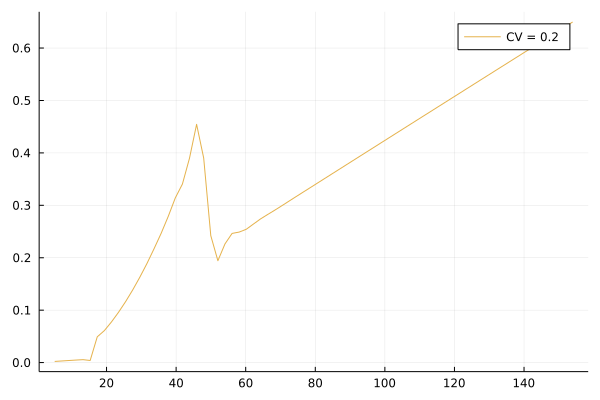

In [651]:
p2 = Plots.plot(exp.(mu_sd1 .+ 0.5*sigma[1]),
broadcast(i -> V([mu_sd1[i], sigma[1]]), 1:length(mu_sd1)).-broadcast(i -> V([mu_sd1[i], sigma[2]]), 1:length(mu_sd1)),
label = "CV = 0.2",c = Colors.RGB(0.9,0.7,0.3))